# P07: Termografía

## Introducción

En esta práctica analizaremos imágenes termográficas utilizando Python. La termografía es una técnica de medición sin contacto que permite visualizar la distribución de temperatura en una superficie mediante la detección de radiación infrarroja.

Realizaremos:
- Carga y visualización de imágenes termográficas
- Análisis de regiones de interés (ROI)
- Histogramas de distribución de intensidad
- Análisis multicanal (RGB y escala de grises)

## 1. Importar librerías y configuración inicial

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io

# Configuración para gráficas de mejor calidad
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Definir ruta a los datos
DATA = Path('..') / '..' / '..' / 'files' / 'p7'

print(f"Ruta de datos: {DATA}")
print(f"Archivos disponibles: {list(DATA.glob('*'))}")

Ruta de datos: ..\..\..\files\p7
Archivos disponibles: [WindowsPath('../../../files/p7/Imagen1.png'), WindowsPath('../../../files/p7/Imagen2.png'), WindowsPath('../../../files/p7/Imagen3.png'), WindowsPath('../../../files/p7/Imagen4.png'), WindowsPath('../../../files/p7/Imagen5.png'), WindowsPath('../../../files/p7/Imagen6.jpg')]


## 2. Función para cargar y visualizar imágenes

Creamos una función que nos permite cargar y mostrar imágenes termográficas.

In [2]:
def load_and_display_image(image_path, title='Imagen Termográfica'):
    """
    Carga y muestra una imagen termográfica.
    
    Parameters:
    -----------
    image_path : str o Path
        Ruta al archivo de imagen
    title : str
        Título para la visualización
    
    Returns:
    --------
    img_pil : PIL.Image
        Objeto de imagen PIL cargado
    """
    try:
        img_pil = Image.open(image_path)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(img_pil)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Información de la imagen
        print(f"Imagen cargada: {image_path}")
        print(f"Tamaño: {img_pil.size}")
        print(f"Modo: {img_pil.mode}")
        
        return img_pil
    
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {image_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

## 3. Función para análisis de ROI (Región de Interés) con histogramas

Esta función nos permite seleccionar una región de la imagen y analizar su distribución de intensidad mediante histogramas.

In [3]:
def plot_histogram_roi(img_pil, roi_coords, channel='L', title_prefix='ROI', bins=256):
    """
    Recorta un ROI de una imagen PIL y muestra el ROI junto con su histograma.
    
    Parameters:
    -----------
    img_pil : PIL.Image
        Imagen PIL cargada
    roi_coords : tuple
        Coordenadas del ROI en formato (left, upper, right, lower)
    channel : str o int
        Canal a analizar:
        - 'L': Escala de grises (Luminancia)
        - 0: Canal Rojo
        - 1: Canal Verde
        - 2: Canal Azul
    title_prefix : str
        Prefijo para los títulos de las gráficas
    bins : int
        Número de bins para el histograma (default: 256)
    
    Returns:
    --------
    roi : PIL.Image
        Imagen recortada del ROI
    histogram : numpy.array
        Valores del histograma calculado
    """
    try:
        # Recortar el ROI
        roi = img_pil.crop(roi_coords)
        
        # Convertir según el canal solicitado
        if channel == 'L':
            # Convertir a escala de grises
            roi_channel = roi.convert('L')
            channel_name = 'Escala de Grises (Luminancia)'
            cmap = 'gray'
        elif channel in [0, 1, 2]:
            # Extraer el canal específico (RGB)
            roi_rgb = np.array(roi)
            roi_channel_data = roi_rgb[:, :, channel]
            roi_channel = Image.fromarray(roi_channel_data)
            channel_names = ['Rojo', 'Verde', 'Azul']
            channel_name = f'Canal {channel_names[channel]}'
            cmaps = ['Reds', 'Greens', 'Blues']
            cmap = cmaps[channel]
        else:
            print(f"Canal '{channel}' no reconocido. Usa 'L', 0, 1, o 2.")
            return None, None
        
        # Convertir a array numpy para calcular histograma
        roi_array = np.array(roi_channel)
        
        # Crear figura con dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Subplot 1: Mostrar el ROI
        axes[0].imshow(roi_channel, cmap=cmap)
        axes[0].set_title(f'{title_prefix} - {channel_name}', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Subplot 2: Histograma
        histogram, bin_edges = np.histogram(roi_array.flatten(), bins=bins, range=(0, 256))
        axes[1].bar(bin_edges[:-1], histogram, width=1, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1].set_title(f'Histograma - {channel_name}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Intensidad de Píxel', fontsize=10)
        axes[1].set_ylabel('Frecuencia', fontsize=10)
        axes[1].grid(axis='y', alpha=0.3)
        
        # Estadísticas
        mean_val = np.mean(roi_array)
        std_val = np.std(roi_array)
        min_val = np.min(roi_array)
        max_val = np.max(roi_array)
        
        stats_text = f'Media: {mean_val:.2f}\nDesv. Est.: {std_val:.2f}\nMin: {min_val}\nMax: {max_val}'
        axes[1].text(0.98, 0.97, stats_text, transform=axes[1].transAxes,
                    fontsize=9, verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nEstadísticas del ROI ({channel_name}):")
        print(f"  Media: {mean_val:.2f}")
        print(f"  Desviación estándar: {std_val:.2f}")
        print(f"  Valor mínimo: {min_val}")
        print(f"  Valor máximo: {max_val}")
        print(f"  Tamaño del ROI: {roi.size}")
        
        return roi, histogram
    
    except Exception as e:
        print(f"Error al procesar el ROI: {e}")
        return None, None

## 4. Análisis de Imagen 1: Aeronave

Cargaremos y visualizaremos la primera imagen termográfica de una aeronave.

Mostrando Imagen 1 - Aeronave:


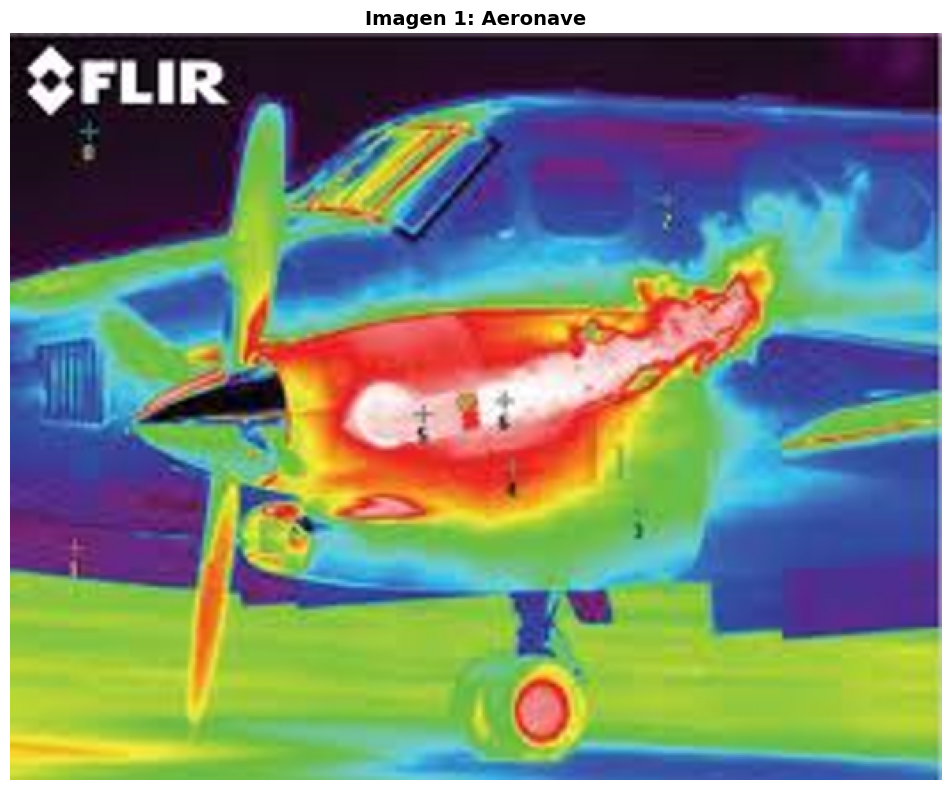

Imagen cargada: ..\..\..\files\p7\Imagen1.png
Tamaño: (524, 420)
Modo: RGBA


In [4]:
# Cargar y mostrar Imagen 1
path_imagen1 = DATA / 'Imagen1.png'
print("Mostrando Imagen 1 - Aeronave:")
img1_pil = load_and_display_image(path_imagen1, title='Imagen 1: Aeronave')

## 5. Análisis de Imagen 2

Cargaremos y visualizaremos la segunda imagen termográfica.

Mostrando Imagen 2:


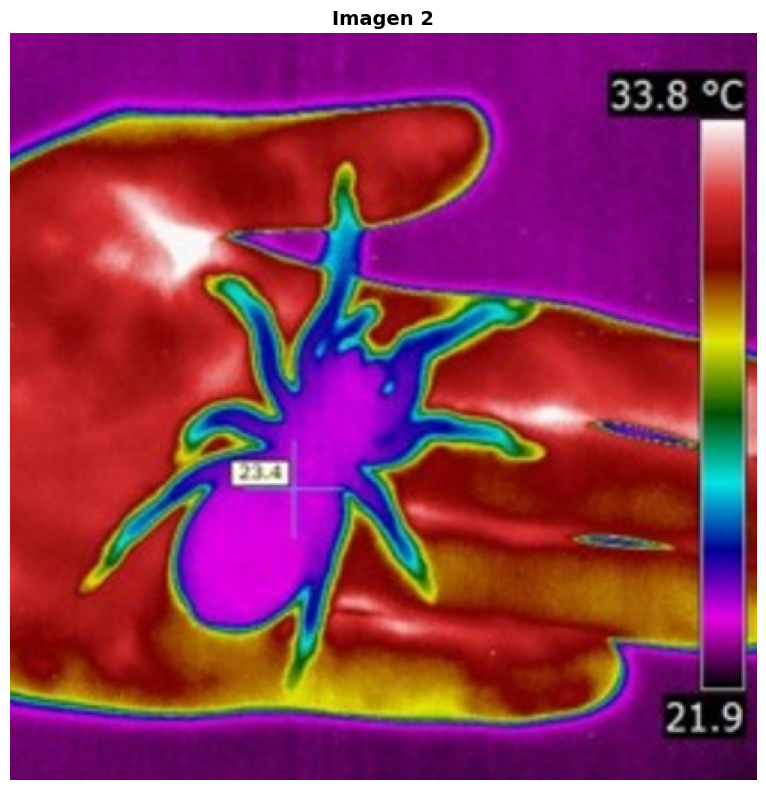

Imagen cargada: ..\..\..\files\p7\Imagen2.png
Tamaño: (420, 420)
Modo: RGBA


In [5]:
# Cargar y mostrar Imagen 2
path_imagen2 = DATA / 'Imagen2.png'
print("Mostrando Imagen 2:")
img2_pil = load_and_display_image(path_imagen2, title='Imagen 2')

## 6. Análisis de Imagen 3

Mostrando Imagen 3:


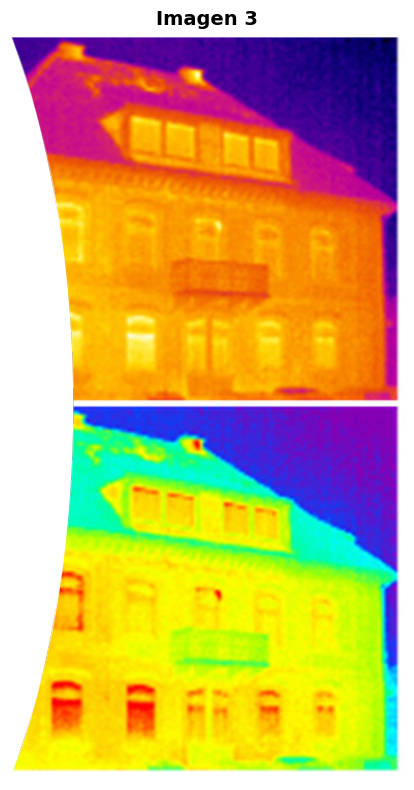

Imagen cargada: ..\..\..\files\p7\Imagen3.png
Tamaño: (380, 720)
Modo: RGBA


In [6]:
# Cargar y mostrar Imagen 3
path_imagen3 = DATA / 'Imagen3.png'
print("Mostrando Imagen 3:")
img3_pil = load_and_display_image(path_imagen3, title='Imagen 3')

## 7. Análisis de Imagen 4

Mostrando Imagen 4:


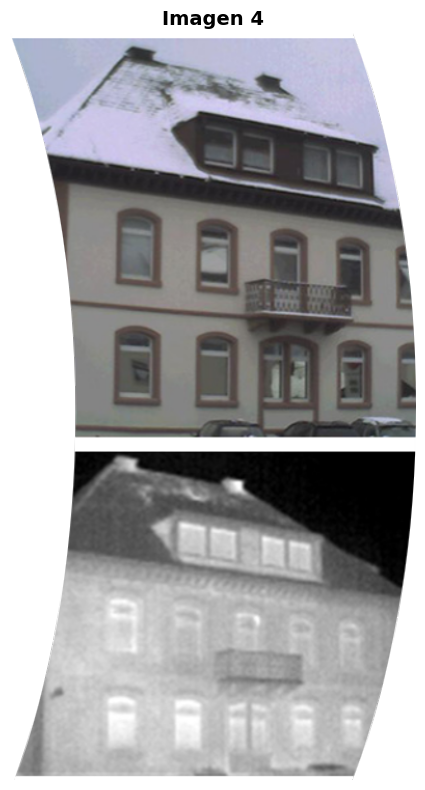

Imagen cargada: ..\..\..\files\p7\Imagen4.png
Tamaño: (391, 720)
Modo: RGBA


In [7]:
# Cargar y mostrar Imagen 4
path_imagen4 = DATA / 'Imagen4.png'
print("Mostrando Imagen 4:")
img4_pil = load_and_display_image(path_imagen4, title='Imagen 4')

## 8. Análisis de Imagen 5

Esta imagen contiene tazas con líquidos a diferentes temperaturas. Analizaremos regiones de interés específicas.

Mostrando Imagen 5:


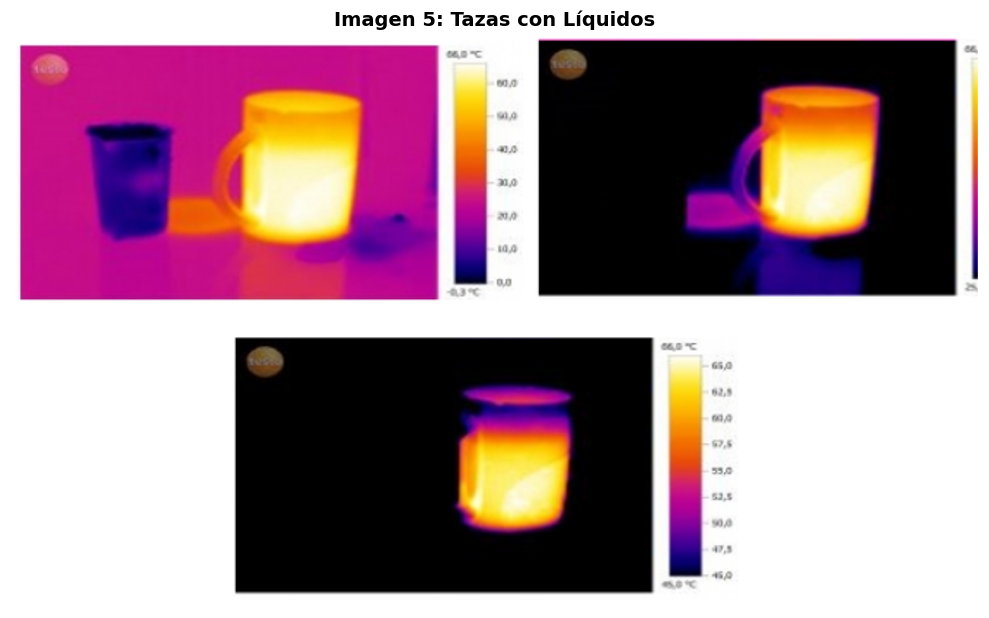

Imagen cargada: ..\..\..\files\p7\Imagen5.png
Tamaño: (864, 512)
Modo: RGBA


In [8]:
# Cargar y mostrar Imagen 5
path_imagen5 = DATA / 'Imagen5.png'
print("Mostrando Imagen 5:")
img5_pil = load_and_display_image(path_imagen5, title='Imagen 5: Tazas con Líquidos')

### 8.1 Análisis de ROI en Imagen 5 - Escala de Grises

Analizaremos una región de interés (ROI) correspondiente a una de las tazas en la Imagen 5. 
Ajusta las coordenadas `roi_coords` según la ubicación de las tazas en la imagen.

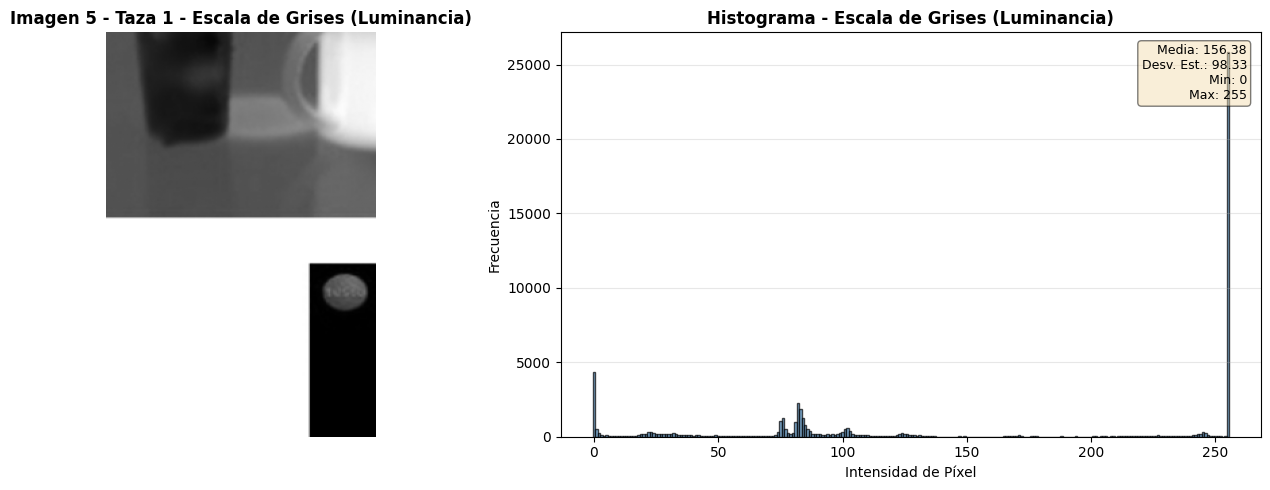


Estadísticas del ROI (Escala de Grises (Luminancia)):
  Media: 156.38
  Desviación estándar: 98.33
  Valor mínimo: 0
  Valor máximo: 255
  Tamaño del ROI: (200, 300)


In [9]:
# Definir coordenadas aproximadas para una taza en Imagen5
# Estas coordenadas son (left, upper, right, lower) - ajustar según la imagen
roi_taza_coords_img5 = (50, 100, 250, 400)  # Ejemplo, ajustar según la imagen real

# Analizar el ROI en escala de grises
if img5_pil:
    plot_histogram_roi(img5_pil,
                      roi_coords=roi_taza_coords_img5,
                      channel='L',
                      title_prefix='Imagen 5 - Taza 1')
else:
    print("Error: No se pudo cargar la Imagen 5")

### 8.2 Análisis de ROI en Imagen 5 - Canal Rojo

Ahora analizaremos la misma región pero enfocándonos en el canal rojo, que típicamente representa las temperaturas más altas en las imágenes termográficas.

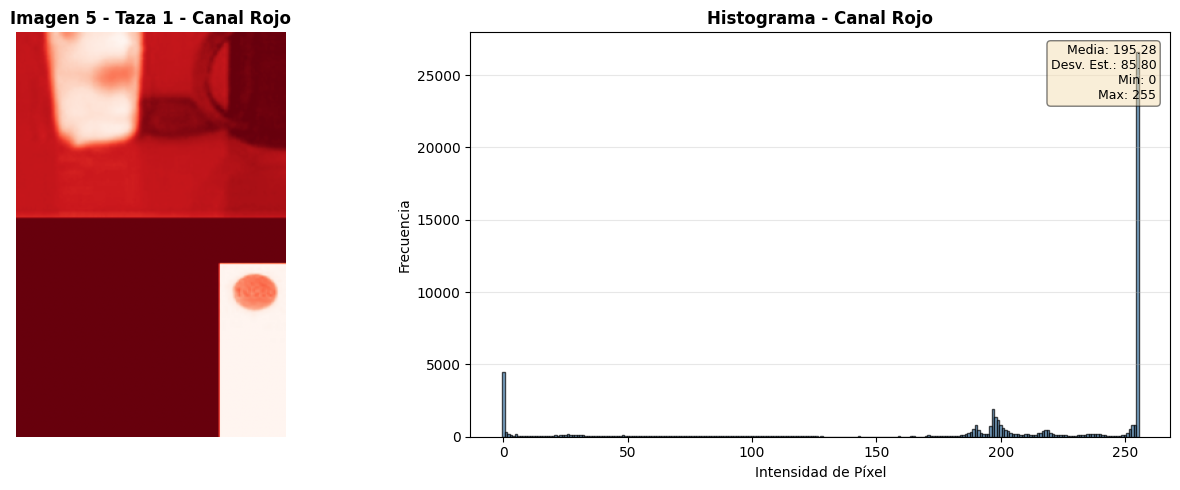


Estadísticas del ROI (Canal Rojo):
  Media: 195.28
  Desviación estándar: 85.80
  Valor mínimo: 0
  Valor máximo: 255
  Tamaño del ROI: (200, 300)


In [10]:
# Analizar el canal rojo del mismo ROI (paleta térmica usa rojo para calor)
if img5_pil:
    plot_histogram_roi(img5_pil,
                      roi_coords=roi_taza_coords_img5,
                      channel=0,  # 0 para Rojo
                      title_prefix='Imagen 5 - Taza 1')
else:
    print("Error: No se pudo cargar la Imagen 5")

## 9. Análisis de Imagen 6

Cargaremos y analizaremos la sexta imagen termográfica disponible.

Mostrando Imagen 6:


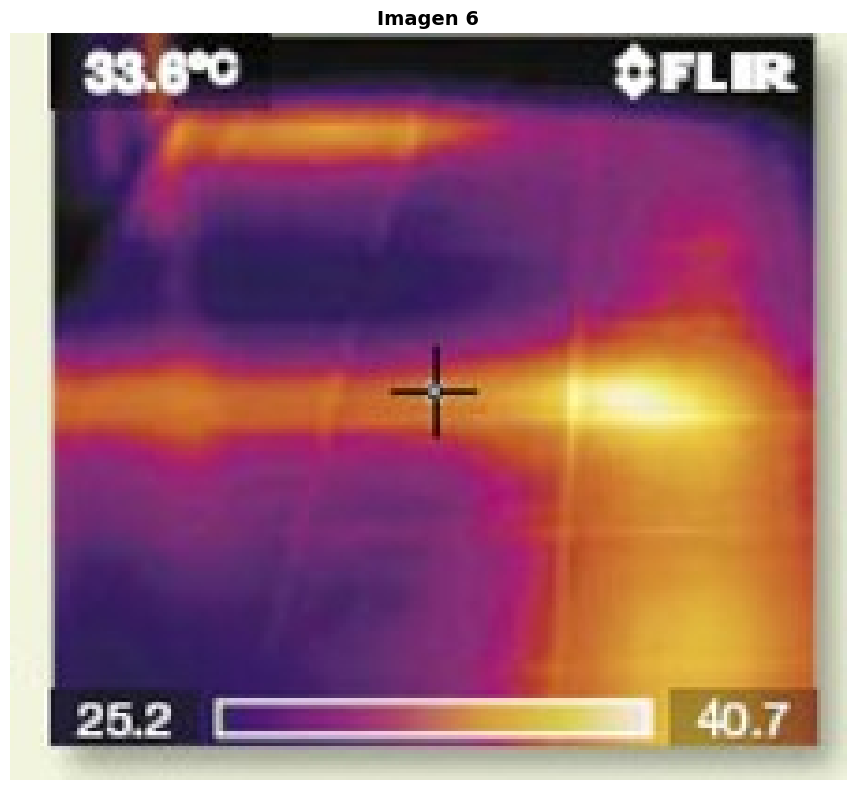

Imagen cargada: ..\..\..\files\p7\Imagen6.jpg
Tamaño: (224, 200)
Modo: RGB


In [11]:
# Cargar y mostrar Imagen 6
path_imagen6 = DATA / 'Imagen6.jpg'
print("Mostrando Imagen 6:")
img6_pil = load_and_display_image(path_imagen6, title='Imagen 6')

## 10. Análisis Comparativo de Múltiples ROIs

Podemos analizar múltiples regiones de interés para comparar temperaturas en diferentes zonas de la imagen.

=== Análisis de Taza 2 - Canal Verde ===


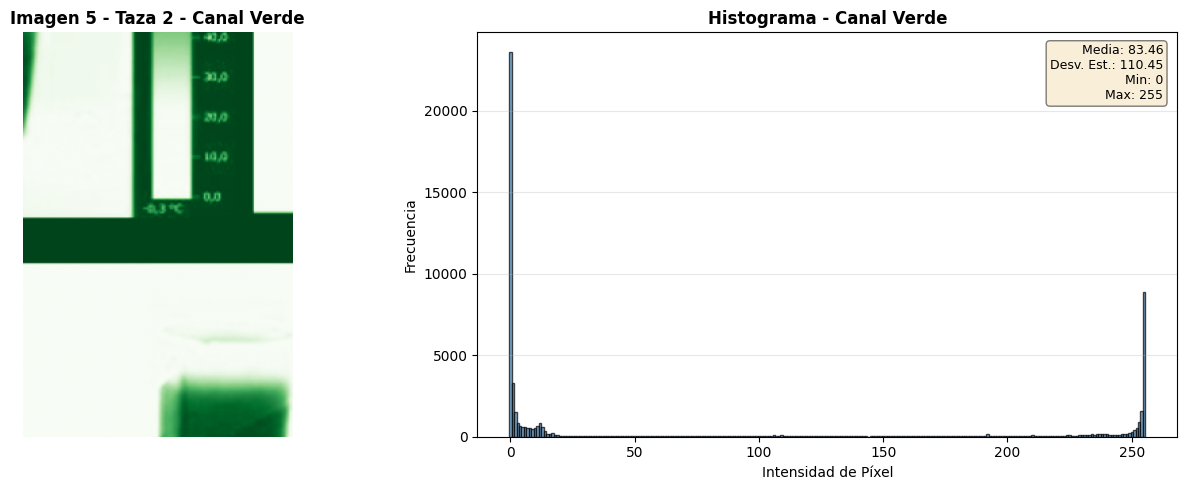


Estadísticas del ROI (Canal Verde):
  Media: 83.46
  Desviación estándar: 110.45
  Valor mínimo: 0
  Valor máximo: 255
  Tamaño del ROI: (200, 300)

=== Análisis de Taza 2 - Canal Azul ===


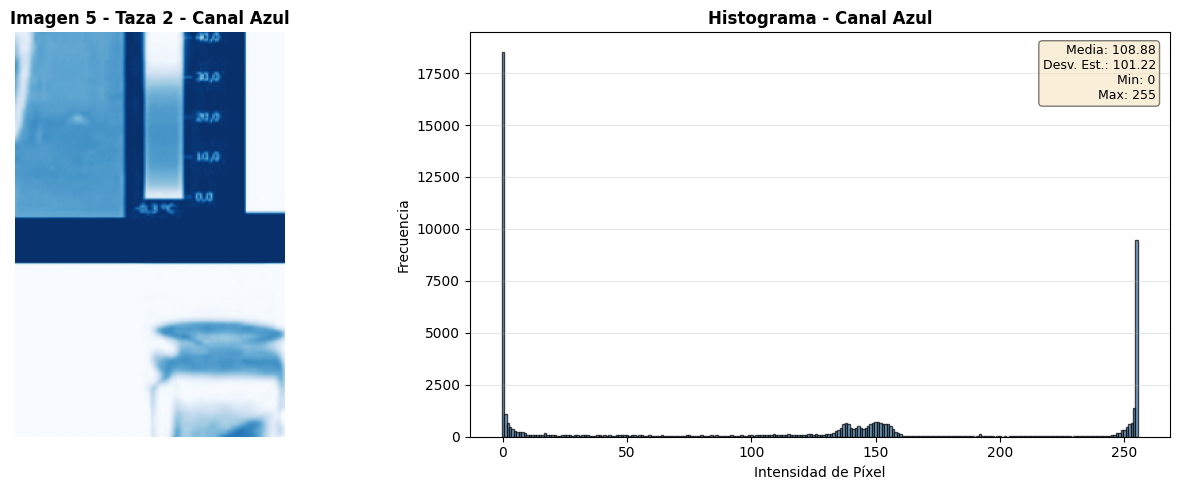


Estadísticas del ROI (Canal Azul):
  Media: 108.88
  Desviación estándar: 101.22
  Valor mínimo: 0
  Valor máximo: 255
  Tamaño del ROI: (200, 300)


In [12]:
# Ejemplo: Analizar múltiples ROIs de la Imagen 5 (si contiene múltiples tazas)
# Definir coordenadas para una segunda taza (ajustar según la imagen)
roi_taza2_coords_img5 = (300, 100, 500, 400)  # Ejemplo, ajustar según la imagen

if img5_pil:
    print("=== Análisis de Taza 2 - Canal Verde ===")
    plot_histogram_roi(img5_pil,
                      roi_coords=roi_taza2_coords_img5,
                      channel=1,  # 1 para Verde
                      title_prefix='Imagen 5 - Taza 2')
    
    print("\n=== Análisis de Taza 2 - Canal Azul ===")
    plot_histogram_roi(img5_pil,
                      roi_coords=roi_taza2_coords_img5,
                      channel=2,  # 2 para Azul
                      title_prefix='Imagen 5 - Taza 2')
else:
    print("Error: No se pudo cargar la Imagen 5")

## 11. Visualización de Todas las Imágenes en un Grid

Creemos una visualización comparativa de todas las imágenes disponibles.

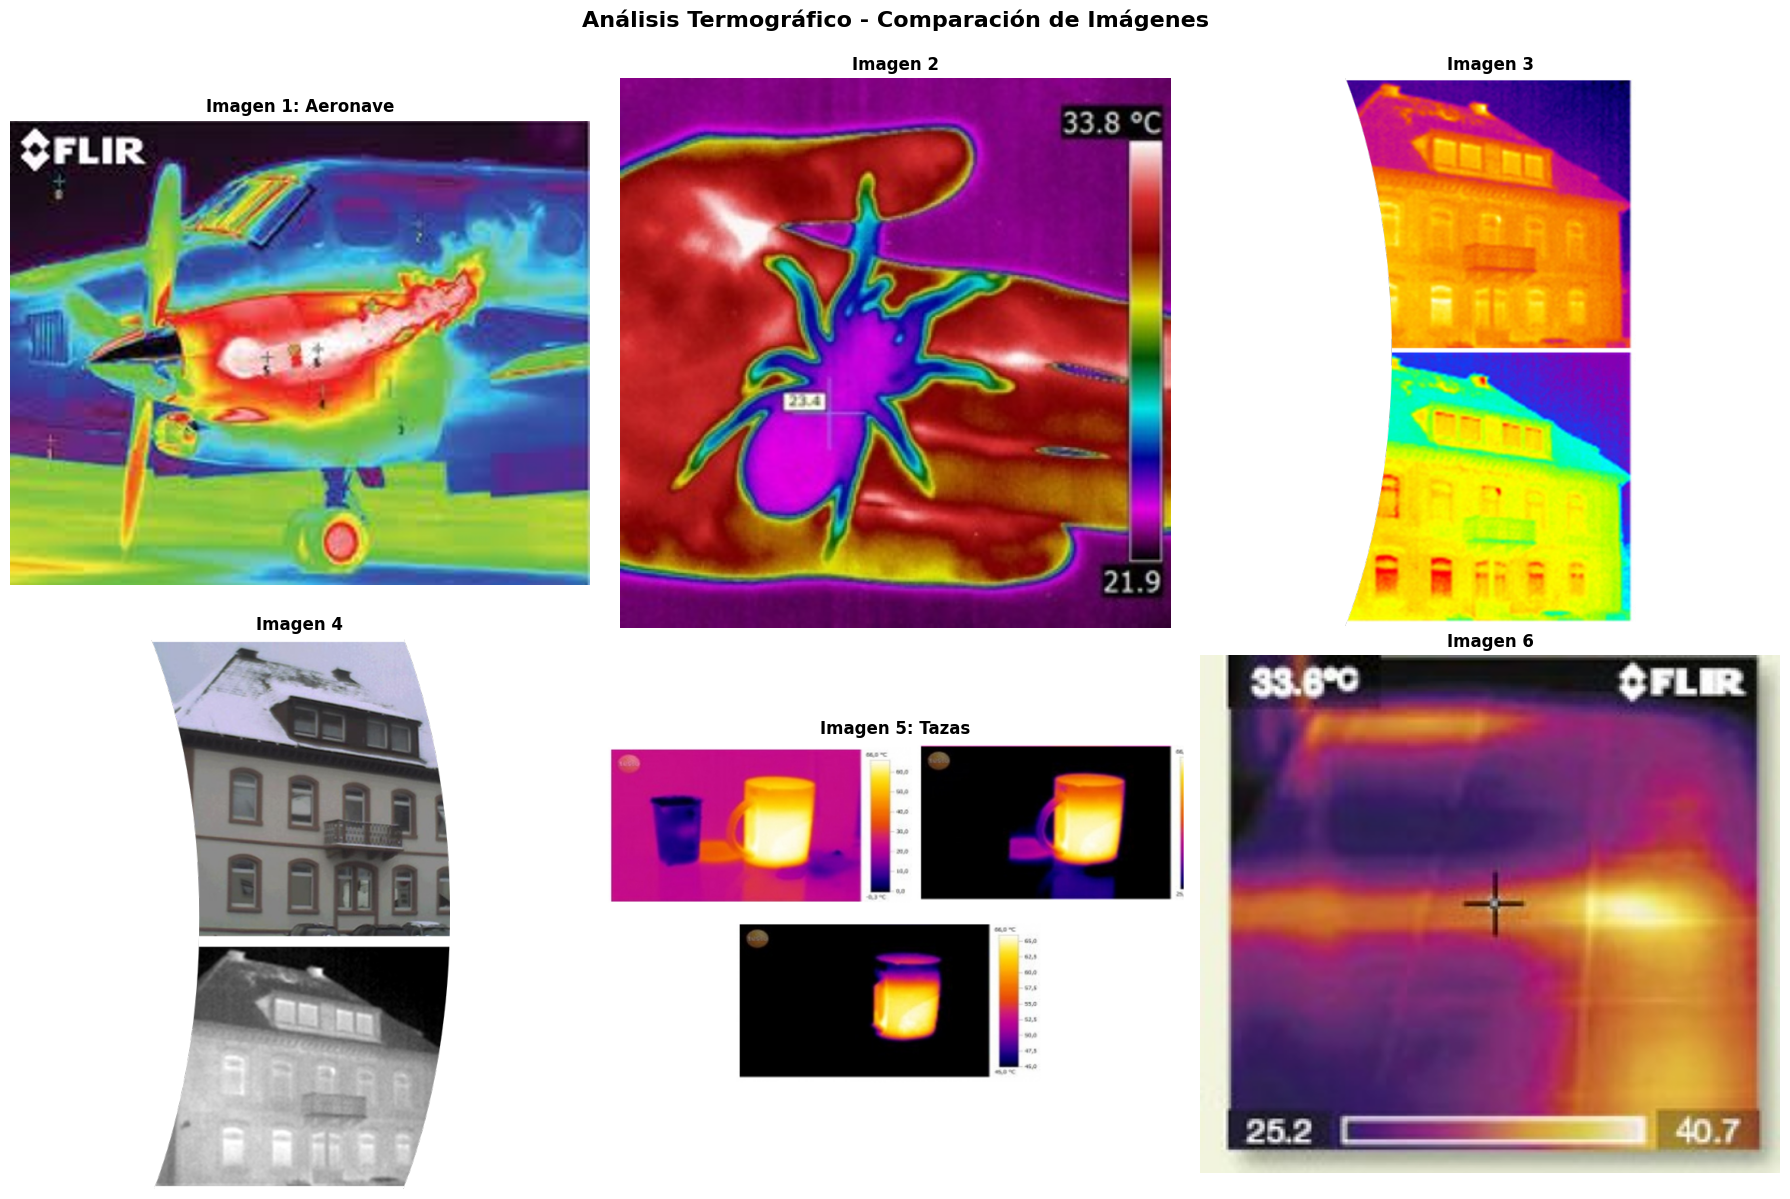

In [13]:
# Visualización de todas las imágenes en un grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Lista de imágenes y títulos
imagenes = [
    (img1_pil, 'Imagen 1: Aeronave'),
    (img2_pil, 'Imagen 2'),
    (img3_pil, 'Imagen 3'),
    (img4_pil, 'Imagen 4'),
    (img5_pil, 'Imagen 5: Tazas'),
    (img6_pil, 'Imagen 6')
]

# Mostrar cada imagen
for idx, (img, titulo) in enumerate(imagenes):
    if img:
        axes[idx].imshow(img)
        axes[idx].set_title(titulo, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'No disponible', 
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.suptitle('Análisis Termográfico - Comparación de Imágenes', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 12. Conclusiones

### Resumen del Análisis Termográfico

En esta práctica hemos realizado un análisis completo de imágenes termográficas utilizando Python:

**Técnicas Aplicadas:**
1. **Carga y visualización** de imágenes termográficas en diferentes formatos (PNG, JPG)
2. **Análisis de ROI** (Regiones de Interés) para estudiar áreas específicas
3. **Histogramas de distribución** para analizar intensidades de píxeles
4. **Análisis multicanal** (RGB y escala de grises) para extraer información térmica

**Observaciones Clave:**
- Las imágenes termográficas utilizan paletas de colores para representar temperaturas
- El canal rojo típicamente representa las zonas más calientes
- El canal azul representa las zonas más frías
- La escala de grises (luminancia) proporciona un análisis de contraste general

**Aplicaciones Prácticas:**
- Detección de puntos calientes en maquinaria
- Análisis de aislamiento térmico en edificaciones
- Medición de temperatura sin contacto
- Inspección de componentes electrónicos
- Estudios de transferencia de calor

### Instrucciones para Uso Personalizado

Para adaptar este notebook a tus propias imágenes:

1. Modifica la variable `DATA` para apuntar a tu carpeta de imágenes
2. Ajusta las coordenadas de los ROIs según tus objetos de interés
3. Experimenta con diferentes canales de color según tu paleta térmica
4. Utiliza las estadísticas (media, desviación estándar) para análisis cuantitativos